In [1]:
!pip install rasterio
!gdown 1Pa7v2OPifwOt7opfjENM6n_ySuz1tVmB
!unzip /content/unet_custom.zip
!gdown 1mWIMBIhJHh8Zx4OOzIM4incqH7ROF1q7

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 29.9 MB/s eta 0:00:00
Downloading...
From: https://drive.google.com/uc?id=1Pa7v2OPifwOt7opfjENM6n_ySuz1tVmB
To: /content/unet_custom.zip
100% 7.11k/7.11k [00:00<00:00, 16.7MB/s]
Archive:  /content/unet_custom.zip
   creating: unet/
  inflating: unet/dice_score.py      
  inflating: unet/parallel.py        
  inflating: unet/inference.py       
  inflating: unet/evaluate.py        
  inflating: unet/unet_parts.py      
 extracting: unet/__init__.py        
  inflating: unet/unet_model.py      
  inflating: unet/dataset.py         
Downloading...
From (original): https://drive.google.com/uc?id=1mWIMBIhJHh8Zx4OOzIM4incqH7ROF1q7
From (redirected): https://drive.google.com/uc?id=1mWIMBIhJHh8Zx4OOzIM4incqH7ROF1q7&confirm=t&uuid=db6fc6fa-eaae-40a7-970a-557d9413d225
To: /content/fold_0_epoch_19.pth
100% 69.1M/69.1M [00:00<00:00, 70.1MB/s]


In [3]:
import os
import sys
import rasterio
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.transforms.functional import crop
from rasterio import windows
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("/content/unet")
from unet.inference import DeadwoodInferenceDataset
from unet.unet_model import UNet
from unet.dataset import get_windows

## download / set orthophoto path

In [4]:
# this is a sample geotif that you can use to test this code
# - comment out gdown and set `inference_file` variable to you path
!gdown 1PRhsT68Rax_V26jjefnKg7gUR_zpPouz
inference_file = "/content/uavforsat_DDH002_ortho.reprojected.0.04.tif"

# init dataset
dataset = DeadwoodInferenceDataset(inference_file, padding=128)

Downloading...
From: https://drive.google.com/uc?id=1PRhsT68Rax_V26jjefnKg7gUR_zpPouz
To: /content/uavforsat_DDH002_ortho.reprojected.0.04.tif
100% 48.3M/48.3M [00:00<00:00, 72.4MB/s]


## load and init model

In [5]:
loader_args = {
    "batch_size": 1,
    "num_workers": 4,
    "pin_memory": True,
    "shuffle": False,
}
inference_loader = DataLoader(dataset, **loader_args)

# preferably use GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model with three input channels (RGB)
model = UNet(n_channels=3, n_classes=1, bilinear=True)
model = nn.DataParallel(model)
model.load_state_dict(torch.load("/content/fold_0_epoch_19.pth",  map_location=device))
model = model.to(memory_format=torch.channels_last, device=device)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Infererence -> iterate through patches, detect deadwood and save

In [6]:
model.eval()

outimage = np.zeros((dataset.height, dataset.width))
for images, cropped_windows in tqdm(inference_loader):
    images = images.to(device=device, memory_format=torch.channels_last)
    with torch.no_grad():
        output = model(images)
        output = torch.sigmoid(output)
        output = (output > 0.3).float()

        # crop tensor by dataset padding
        output = crop(
            output,
            top=dataset.padding,
            left=dataset.padding,
            height=dataset.tile_size - (2 * dataset.padding),
            width=dataset.tile_size - (2 * dataset.padding),
        )

        # derive min/max from cropped window
        minx = cropped_windows["col_off"]
        maxx = minx + cropped_windows["width"]
        miny = cropped_windows["row_off"]
        maxy = miny + cropped_windows["width"]

        # save tile to output array
        outimage[miny:maxy, minx:maxx] = output[0][0].cpu().numpy()

  0%|          | 0/667 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 667/667 [00:50<00:00, 13.29it/s]


## Plotting

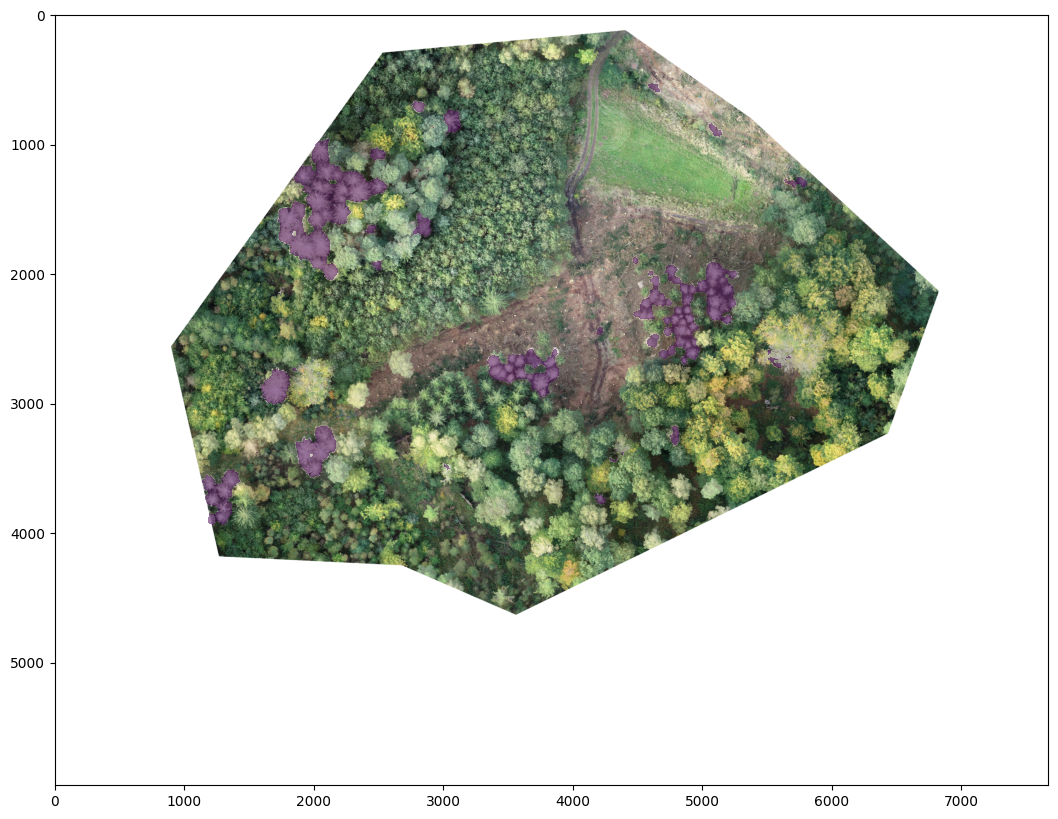

In [7]:
# PLOT ORTHOPHOTO
fig, ax = plt.subplots(figsize=(20,10))
with rasterio.open(inference_file) as dr:
  ax.imshow(np.moveaxis(dr.read(), 0, -1),
            zorder=0)

# PLOT LABELS
# set 0 to Nan, so that non-deadwood is transparent
outimage[outimage==0] = np.nan
ax.imshow(outimage, alpha=0.5)
plt.show()

In [31]:
inference_rast = rasterio.open(inference_file)

# define crs, etc..
metadata = {
    'driver': 'GTiff',
    'height': outimage.shape[0],
    'width': outimage.shape[1],
    'count': 1,
    'dtype': outimage.dtype,
    'crs': inference_rast.crs,  # This is an example, replace with your actual CRS
    'transform': inference_rast.transform
}

# Open a new raster file with the specified CRS and write the numpy array to it
with rasterio.open(inference_file.replace(".tif", "") + '_prediction.tif', 'w', **metadata) as dst:
    dst.write(outimage, 1)